## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GRU, Flatten, MaxPool2D, MaxPool1D
from tensorflow.keras.layers import PReLU, Dropout, Lambda, Dense
from tensorflow.keras.models import Model

from scipy.signal import stft

from music_generator.basic.random import generate_dataset
from music_generator.basic.signalproc import SamplingInfo
from music_generator.musical.timing import Tempo
from music_generator.musical.scales import GenericScale
# from music_generator.analysis.play import play_mono_as_stereo, play_array
from music_generator.basic.signalproc import mix_at
from music_generator.analysis import preprocessing

from music_generator.musical import scales
import numpy as np
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
import matplotlib

from scipy.io.wavfile import read
import pandas as pd

In [9]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)

## Load & show & play music

Before we start out, how do we read audio files?

In [11]:
from scipy.io.wavfile import read
sr, data_raw = read('../data/full-mix.wav')

/home/marcelra/PycharmProjects/mg-desktop/venv/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


The sample rate is the number of samples per second of audio. CD-quality music contains 44100 samples per second. 

In [12]:
data_raw[50000:50100]

array([-350, -319, -314, -323, -334, -336, -325, -282, -211, -111,   13,
        148,  293,  437,  578,  720,  877, 1043, 1215, 1389, 1564, 1745,
       1931, 2133, 2355, 2597, 2849, 3117, 3393, 3676, 3957, 4221, 4463,
       4656, 4788, 4850, 4856, 4805, 4712, 4599, 4499, 4454, 4465, 4545,
       4695, 4902, 5141, 5382, 5618, 5826, 6004, 6155, 6282, 6400, 6509,
       6611, 6714, 6804, 6880, 6923, 6926, 6895, 6818, 6703, 6555, 6394,
       6226, 6058, 5903, 5773, 5674, 5602, 5553, 5513, 5472, 5427, 5376,
       5312, 5229, 5123, 4994, 4850, 4686, 4496, 4282, 4045, 3789, 3523,
       3254, 3001, 2779, 2590, 2442, 2316, 2204, 2095, 1987, 1885, 1778,
       1671], dtype=int16)

* Data is stored as signed integers. We would like to convert to floating point numbers between -1, 1

* What do these numbers mean?

In [13]:
data_raw.shape

(11041758,)

Since we have loaded mono music, the data is 1D.

In [14]:
sr

44100

The highest frequency that can be encoded is then 22 kHz (44100/2), which is already higher than the maximum frequency that we can hear (~20 kHz, but decreases with age). 

In [15]:
data = pd.Series(data_raw)
data.index = data.index / sr
data = data / 2**15 

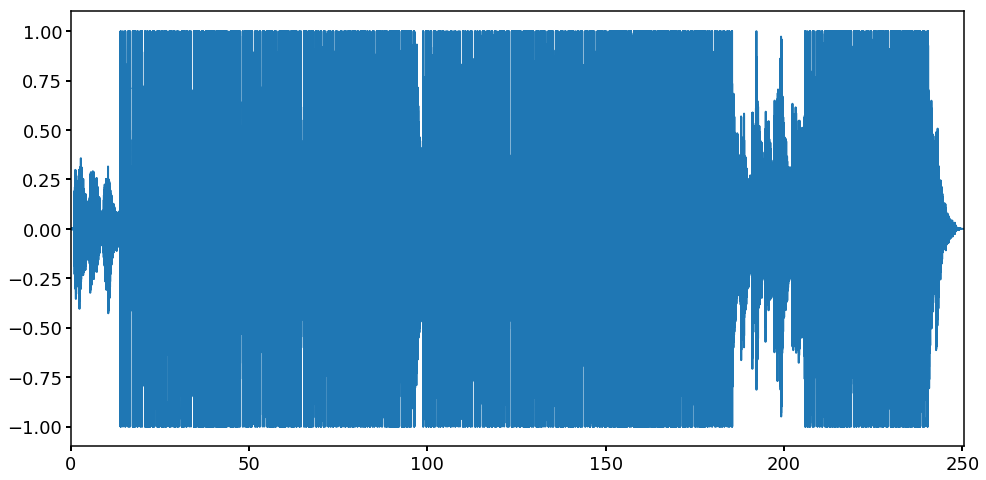

In [16]:
data.plot();

A very nice tool when working with audio is the Audio element in `IPython.display`

```from IPython.display import Audio```

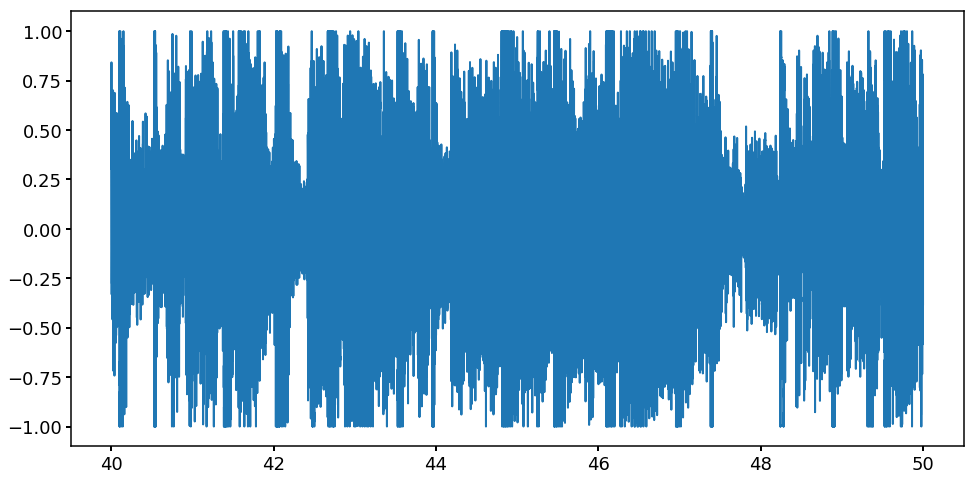

In [17]:
plt.plot(data.loc[40:50])
Audio(data.loc[40:50].values, rate=sr)

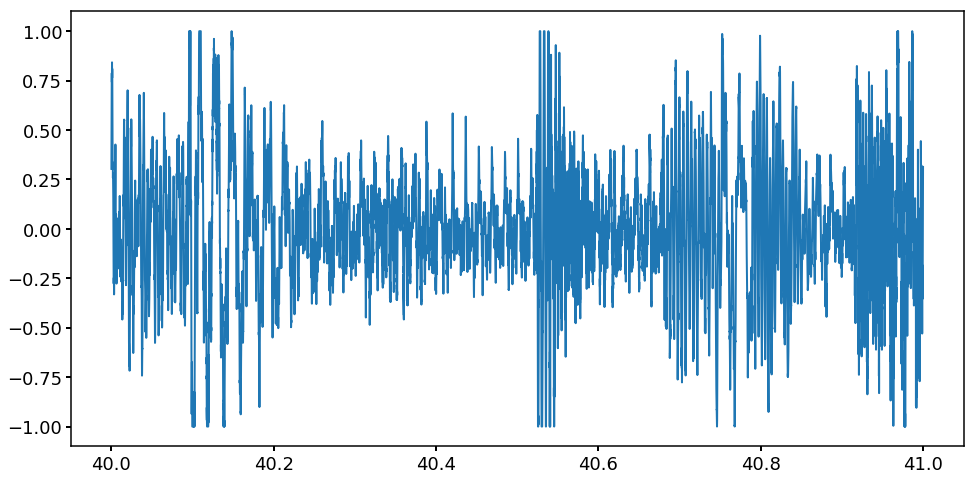

In [18]:
plt.plot(data.loc[40:41])
Audio(data.loc[40:41].values, rate=sr)

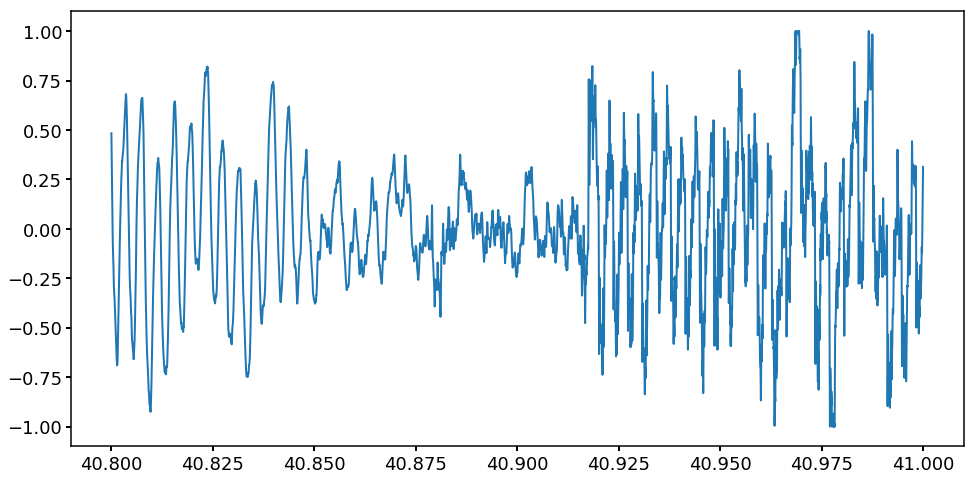

In [19]:
plt.plot(data.loc[40.8:41])
Audio(data.loc[40.8:41].values, rate=sr)

## Simple synthesizer: tone generation

### Sine generator

$$ f(t) = \sin(2 \pi f t)$$

In [20]:
generated = pd.DataFrame({'time': np.arange(0, 1, 1/sr)}).set_index('time')
generated['sine'] = np.sin(generated.index * 440 * 2 * np.pi)

In [21]:
generated.head()

sine
time              
0.000000  0.000000
0.000023  0.062648
0.000045  0.125051
0.000068  0.186961
0.000091  0.248138

In [22]:
def plot_and_play(df, col_name):
    fig, ax = plt.subplots(ncols=2)

    plt.sca(ax[0])
    plt.title('All data')
    df[col_name].plot()

    plt.sca(ax[1])
    plt.title('Zoomed in')
    df.loc[0:0.02][col_name].plot()
    
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title('Spectral')
    f_vec, t_vec, Zxx = stft(df[col_name], sr, nperseg=2048, noverlap=2048 // 4)
    plt.pcolormesh(t_vec, f_vec, np.abs(Zxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0, 5000])
    
    plt.show()

    return Audio(df[col_name], rate=sr)

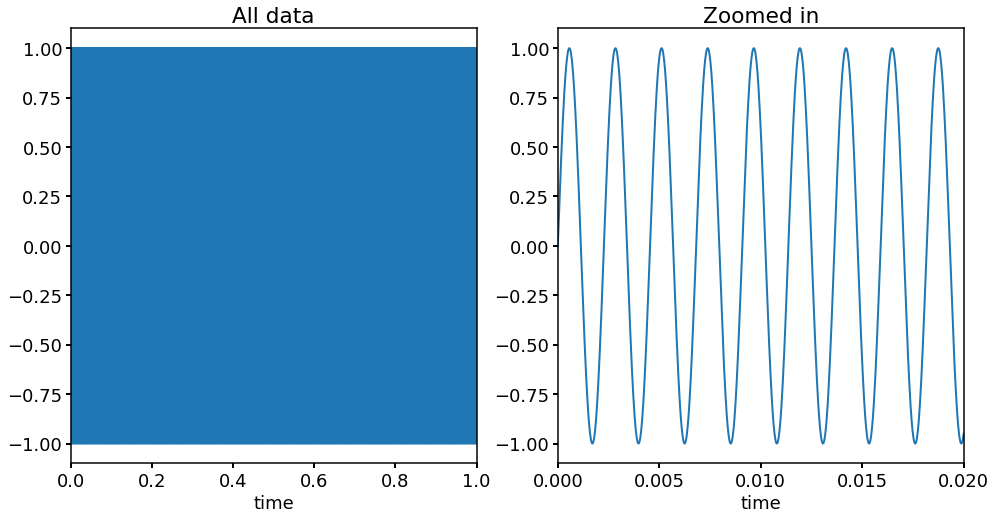

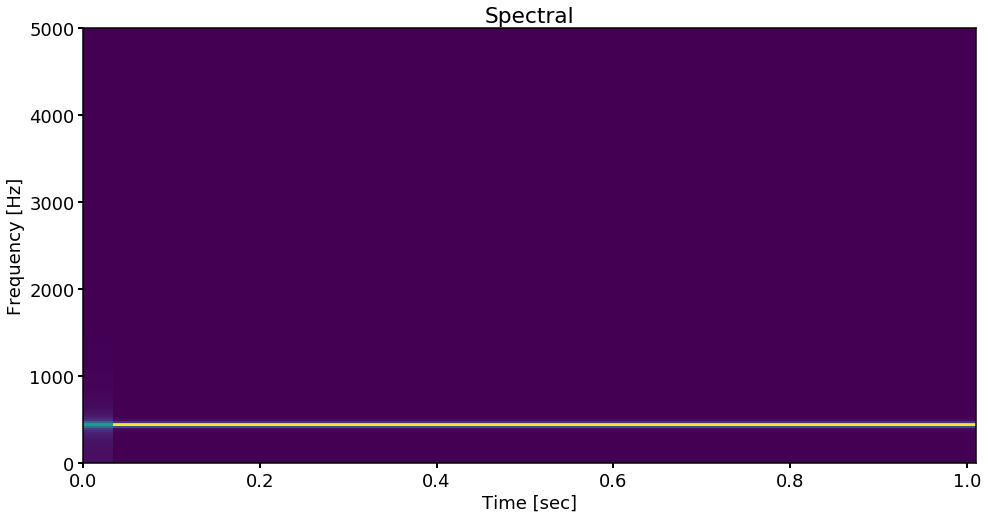

In [23]:
plot_and_play(generated, 'sine')

### Envelope

In [24]:
dr = 0.2
generated['decay_envelope'] = np.exp(-generated.index / dr)
generated['decay_sine'] = generated['sine'] * generated['decay_envelope']

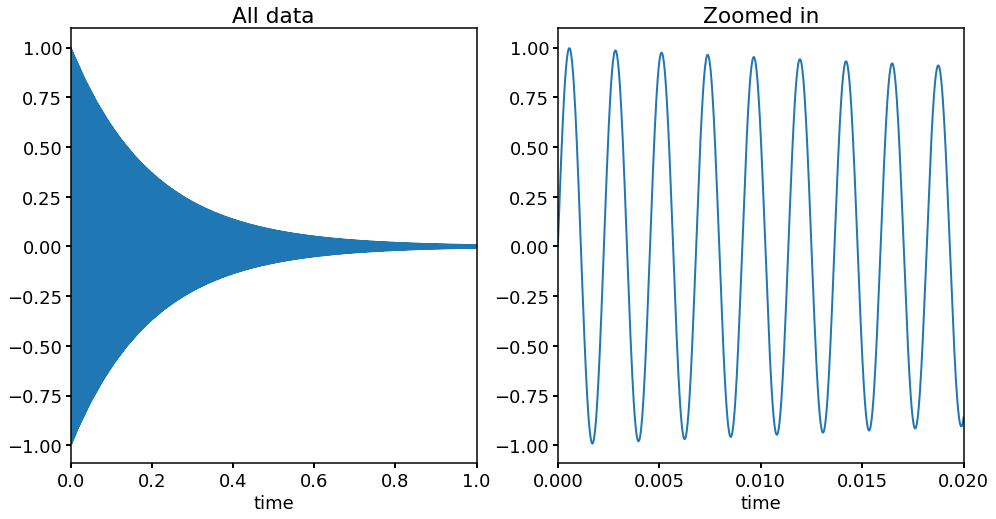

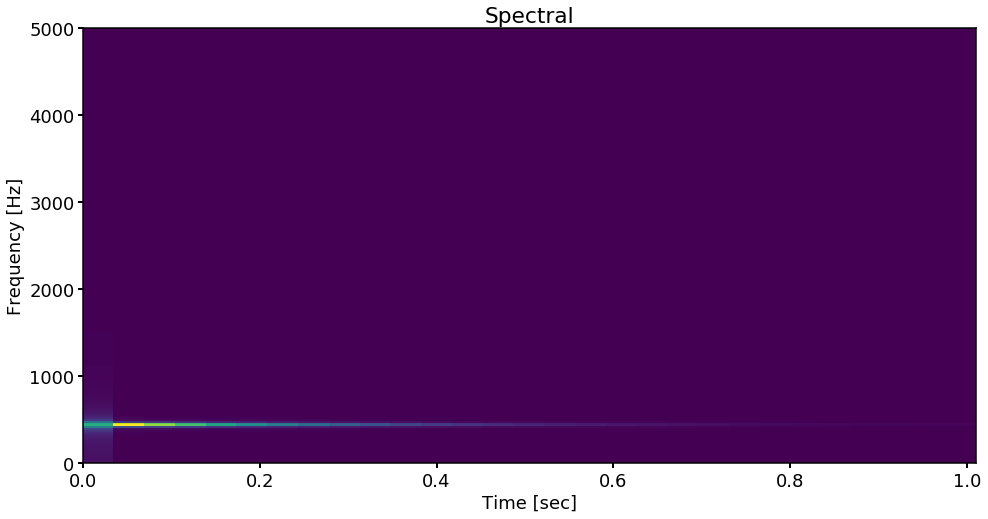

In [25]:
plot_and_play(generated, 'decay_sine')

### Additive synthesis

The sine that we have generated had a frequency. Let's call this the fundamental frequency.

If we add sine wave with a frequency that is a multiple of the fundamental frequency, the whole wave form is still periodic with period that corresponds to the fundamental frequency. Our ears and brains understand this and the tone is perceived as having the same pitch.

Typically we say that the tone changes colour (or timbre)

In [26]:
def additive_synthesis(t, amps, freqs, phases):
    return np.sum([amp * np.sin(t * freq * 2 * np.pi + phase) 
                   for amp, freq, phase in zip(amps, freqs, phases)], 
                  axis=0)

In [27]:
dr = 0.2

amps = [1, -0.3, 0.1, -0.1, 0.4, 0.01, -0.2]
freqs = [440, 2*440, 3*440, 4*440, 5*440, 6*440, 7*440]
phases = [0, 0, 0, 0, 0, 0, 0]

generated['additive'] = additive_synthesis(generated.index, amps, freqs, phases)
generated['additive_decay'] = generated['additive'] * generated['decay_envelope']

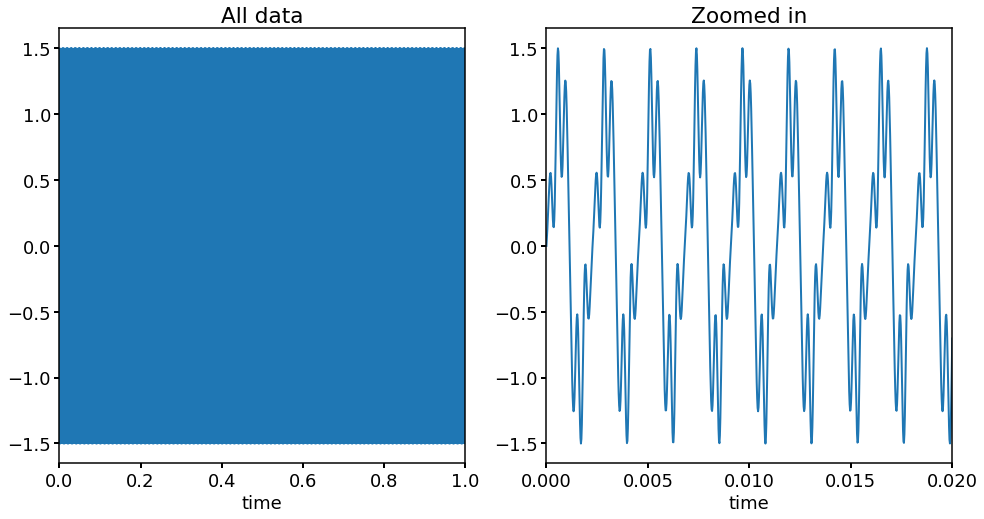

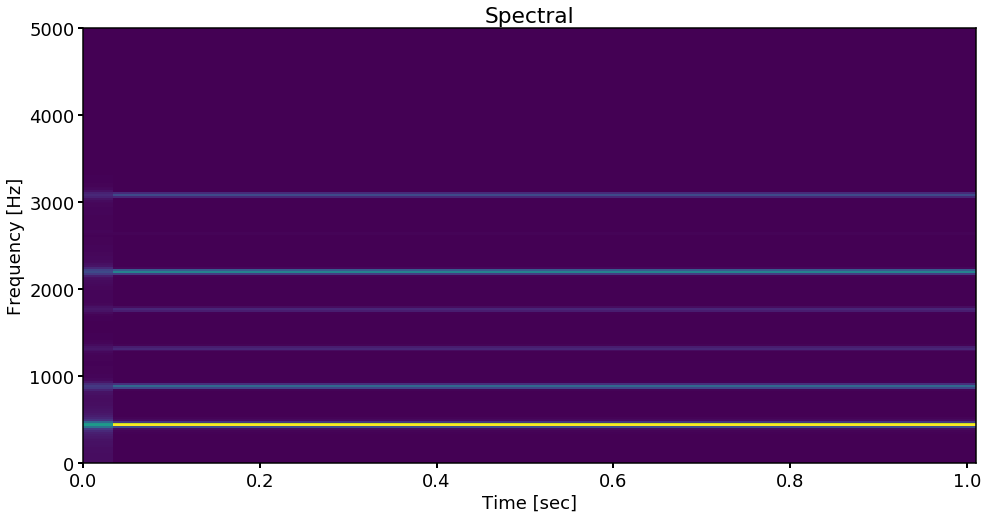

In [28]:
plot_and_play(generated, 'additive')

## Note that indeed it has the same pitch

In [29]:
Audio(generated['additive'], rate=sr)

In [30]:
Audio(generated['sine'], rate=sr)

## The phases are inaudible*!

`*` in mono-sound, for stereo sound it add a spatial feeling to the sound

In [31]:
dr = 0.2

amps = [1, -0.3, 0.1, -0.1, 0.4, 0.01, -0.2]
freqs = [440, 2*440, 3*440, 4*440, 5*440, 6*440, 7*440]
phases = np.random.uniform(0, 2*np.pi, size=len(freqs))

generated['additive_random_phase'] = additive_synthesis(generated.index, amps, freqs, phases)

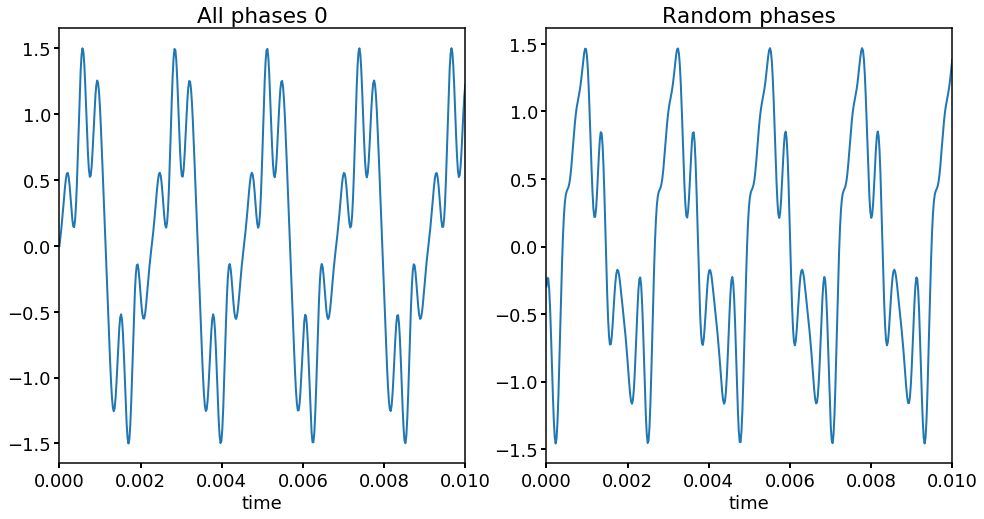

In [35]:
fig, ax = plt.subplots(ncols=2)

plt.sca(ax[0])
plt.title('All phases 0')
generated.loc[0:0.01]['additive'].plot()

plt.sca(ax[1])
plt.title('Random phases')
generated.loc[0:0.01]['additive_random_phase'].plot()

In [36]:
Audio(generated['additive'], rate=sr)

In [37]:
Audio(generated['additive_random_phase'], rate=sr)

## Decay applied on the additive sound

In [38]:
generated['additive_decay'] = generated['additive'] * generated['decay_envelope']

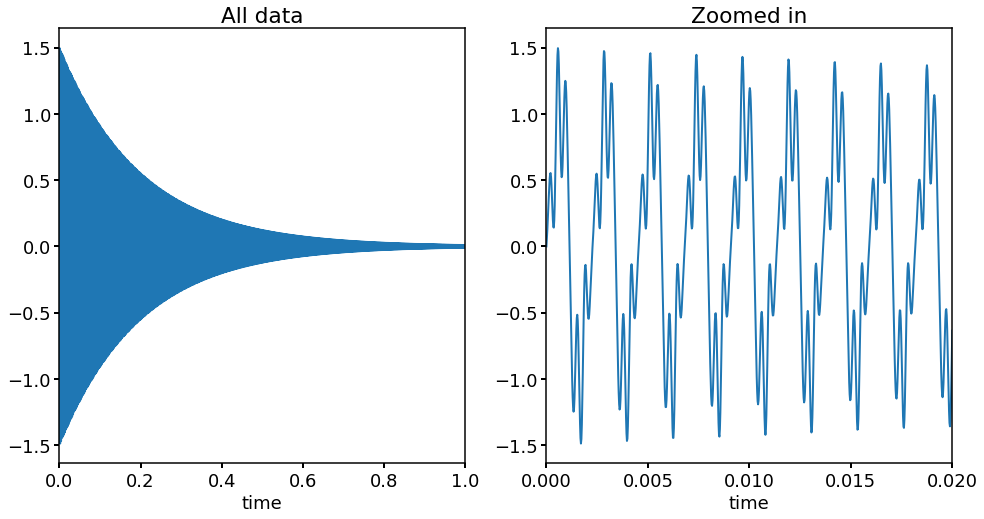

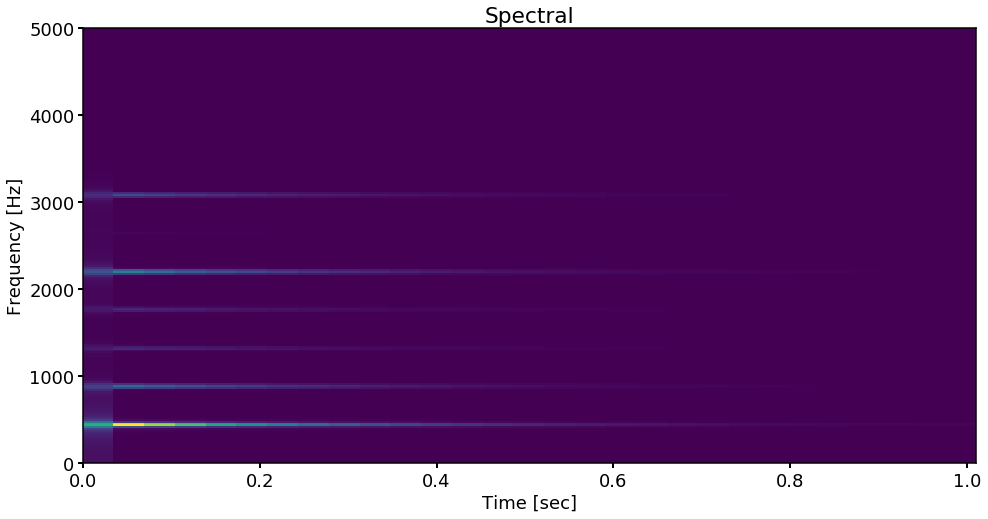

In [39]:
plot_and_play(generated, 'additive_decay')

### Drums

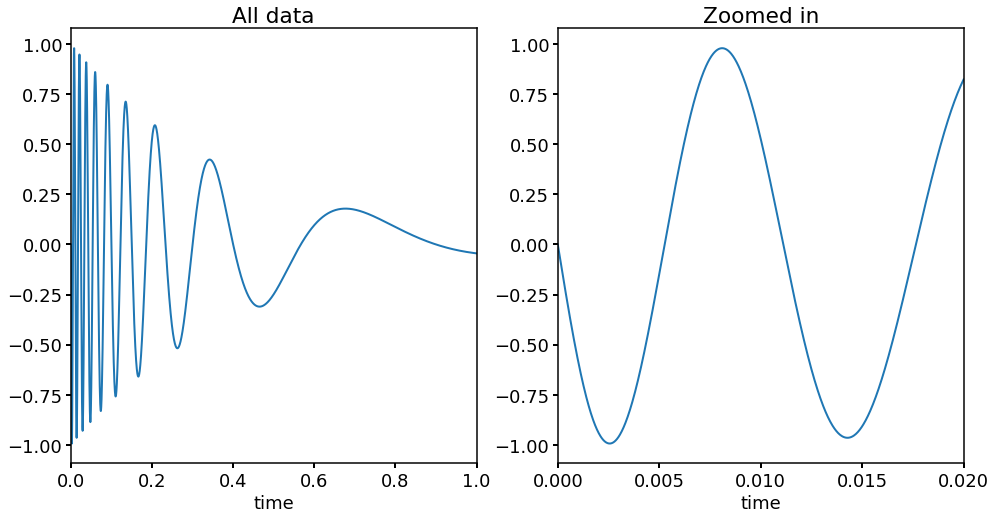

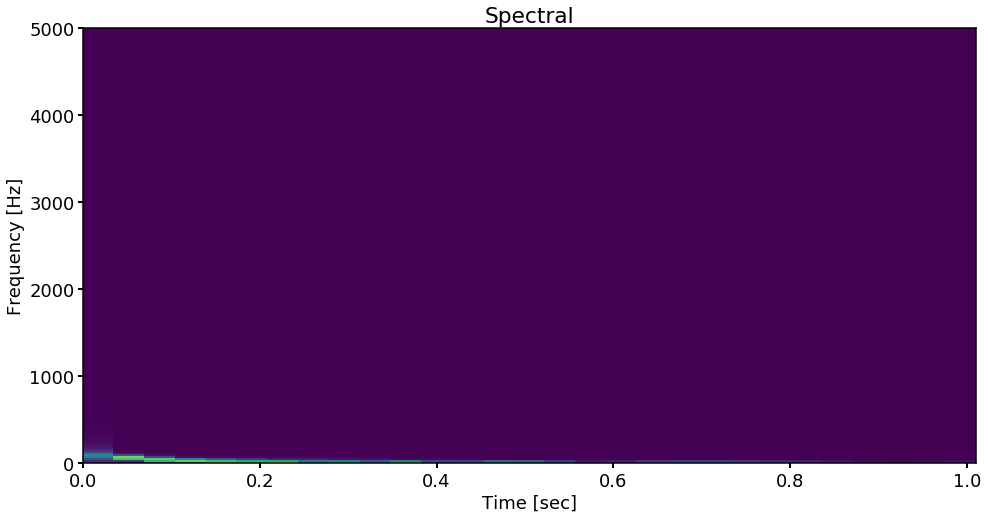

In [40]:
generated['kick'] = np.sin( (1 / (generated.index + 0.1) + 30 ) * 2 * np.pi)
generated['kick'] *= np.exp(-generated.index / 0.4)
plot_and_play(generated, 'kick')

### Snare

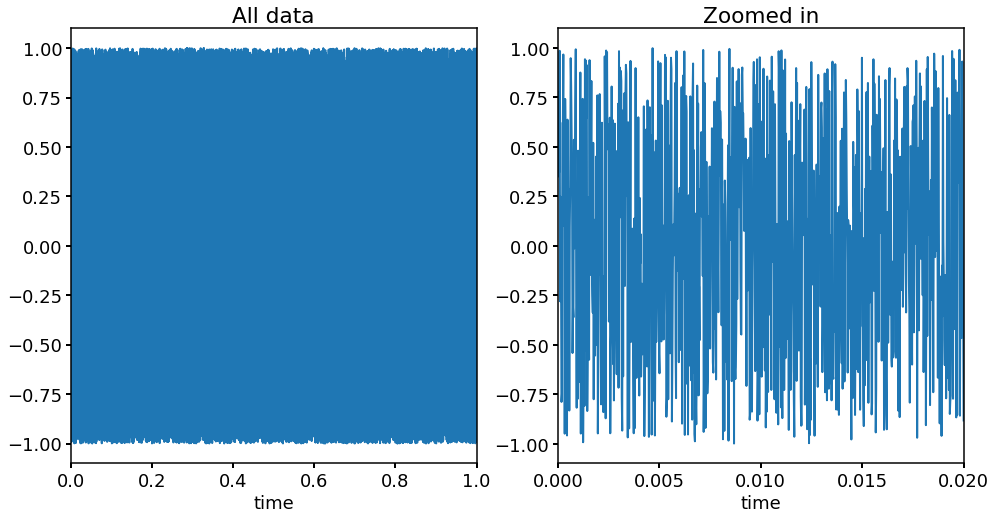

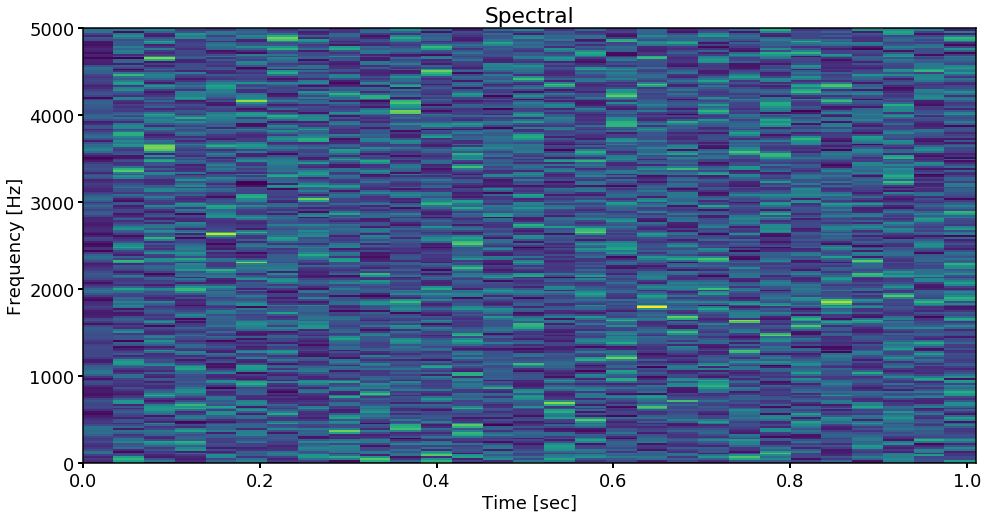

In [41]:
generated['noise'] = np.random.uniform(low=-1, high=1, size=generated.index.shape)
plot_and_play(generated, 'noise')

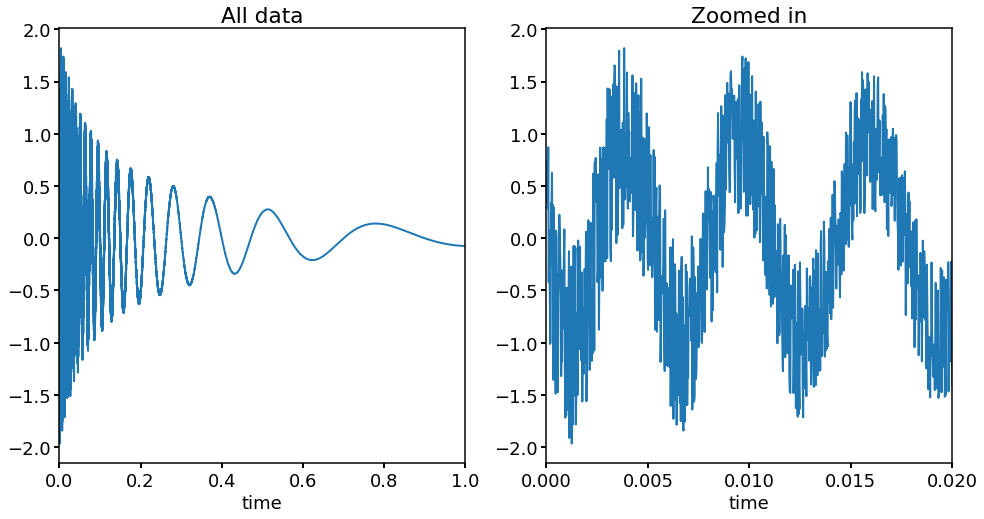

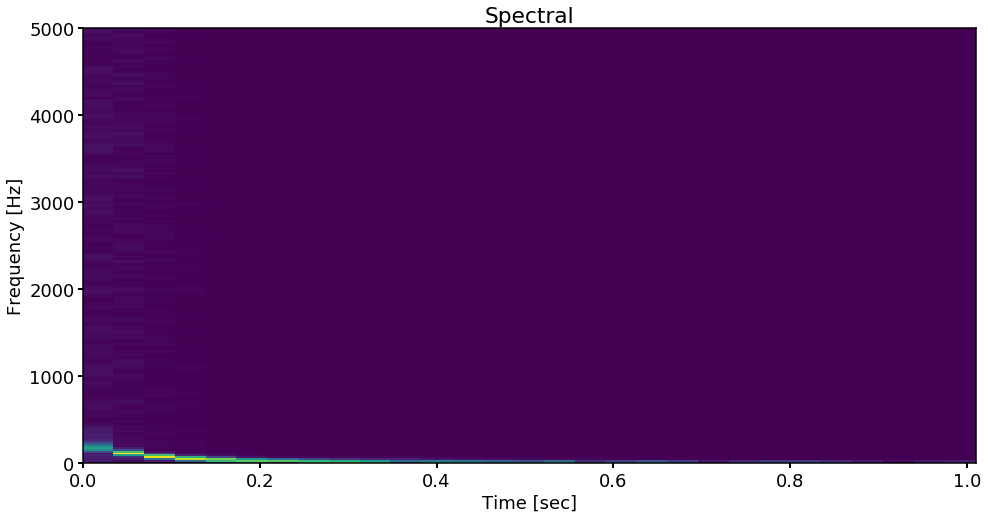

In [43]:
generated['short_decay'] = np.exp(-generated.index / 0.05)
generated['snare_base'] = np.sin( (1 / (generated.index + 0.1) + 30 ) * 4 * np.pi) * np.exp(-generated.index / 0.4)
generated['snare'] = generated['snare_base'] + generated['noise'] * generated['short_decay']
plot_and_play(generated, 'snare')

### Subtractive synthesis

The main idea behind subtractive synthesis is to start with a basic wave shape that has a lot of harmics and then apply frequency filters on it in order to remove part of the frequency content. 

The filter characteristics can have their own envelopes which can give the sound its own dynamics. For instance, when the tone is struck it can be very bright and slowly becomes more dull as the tone lasts longer. This makes it possible to approximate plucked string tones such as harp, piano or guitar.

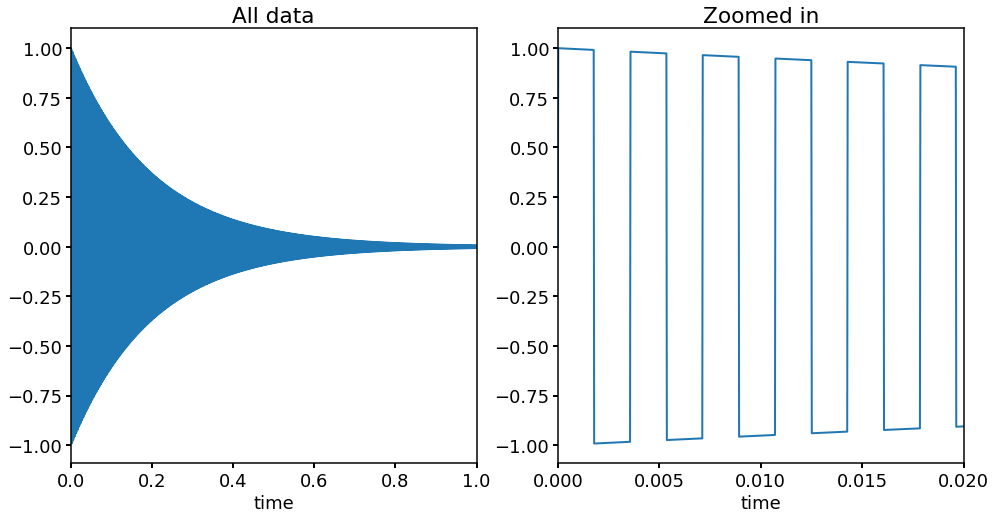

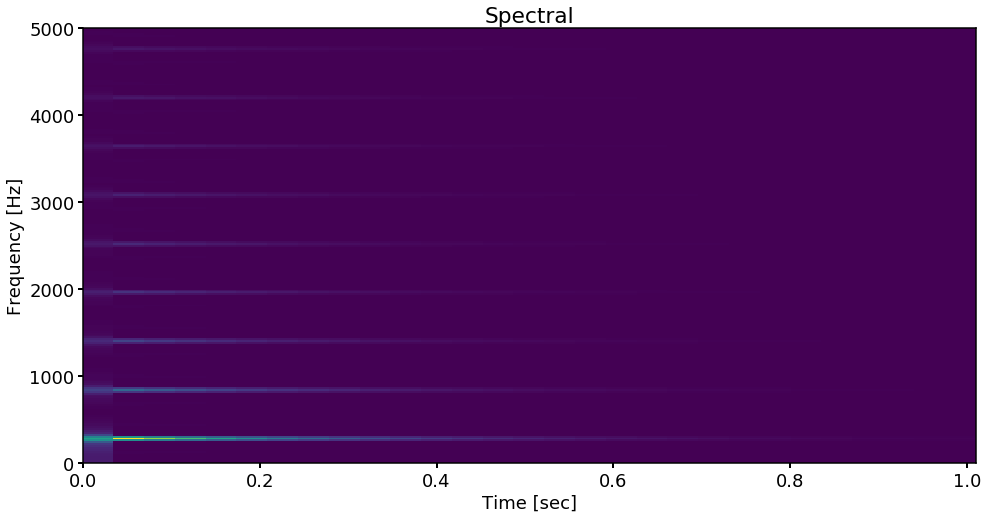

In [44]:
generated['square'] = np.sign(np.sin(generated.index * 440 * 4)) * generated['decay_envelope']
plot_and_play(generated, 'square')

In [45]:
from music_generator.basic.signalproc import apply_filter

In [46]:
generated['filtered_square'] = apply_filter(generated['square'].values, 
                                            SamplingInfo(sr), 3000, order=5, ftype='lowpass')

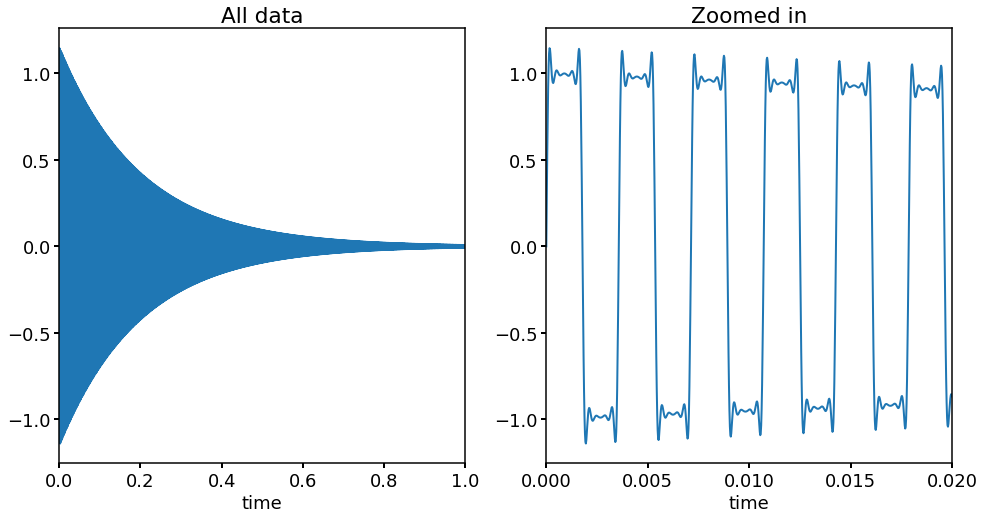

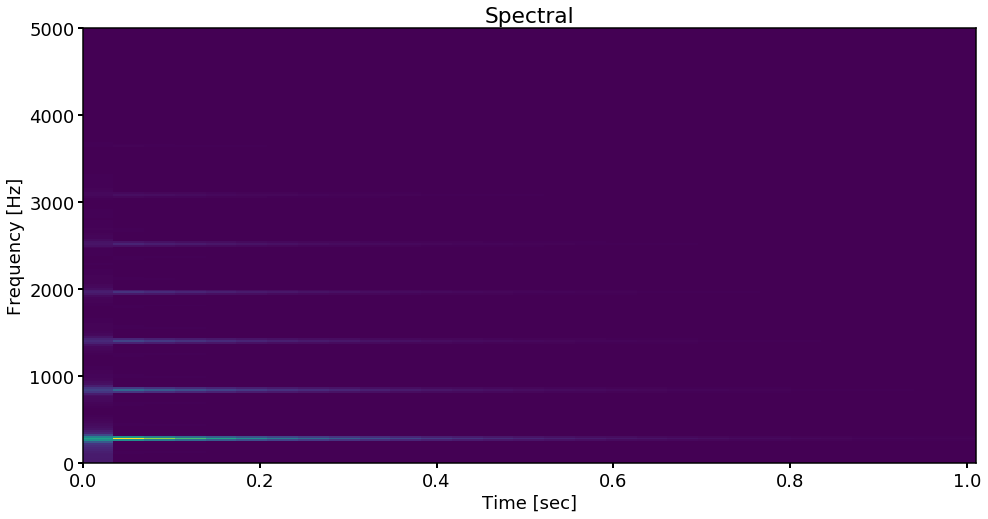

In [47]:
plot_and_play(generated, 'filtered_square')

## There is much more to it

* Effects: distortion, bit-crushing, delay, reverb, chorus, ring modulation, ...
* FM synthesis: a different way of generating tones
* Synthesis using sampling (wavetable synthesis)
* Physical modeling: model air flow in a saxophone, resonances in a grand piano, etc.
* LFO: low-frequency oscillators